# Achilles on BigQuery

This is an attempt to replicate some reports from [Achilles](http://www.ohdsi.org/web/wiki/doku.php?id=documentation:software:achilles) in order to characterize synthetic datasets stored in BigQuery.

In [1]:
%load_ext google.datalab.kernel
%matplotlib inline

import google.datalab.bigquery as bq
import matplotlib.pyplot as plt
import pandas as pd

## Total Persons

In [4]:
%%bq query --name personsTotal

select count(*) FROM test_run_achilles_merge_jan4.fake_person

In [5]:
df_person_with_total = personsTotal.execute(output_options=bq.QueryOutput.dataframe()).result()
df_person_with_total.f0_.values[0]

946237

# Person by Gender

In [2]:
%%bq query --name populationByGender

WITH gender_count AS
(SELECT 
 gender_concept_id,
 COUNT(1) n
FROM `test_merge_dec26.person`
GROUP BY gender_concept_id)

SELECT
 gc.gender_concept_id concept_id,
 c.concept_name,
 gc.n
FROM gender_count gc
  JOIN `test_merge_dec26.concept` c 
    ON gc.gender_concept_id = c.concept_id

In [3]:
df = populationByGender.execute(output_options=bq.QueryOutput.dataframe()).result()

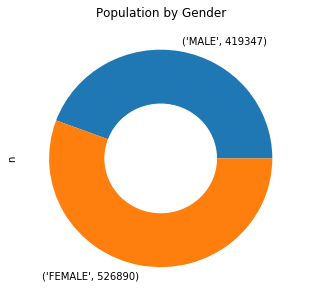

In [6]:
f, ax = plt.subplots(figsize=(5, 5))
labels = df.concept_name.values
sizes = df.n.values

my_circle = plt.Circle((0,0), 0.5, color='white')
df.plot(title='Population by Gender', kind='pie', y='n', labels=zip(labels, sizes), ax=ax)
plt.gcf().gca().add_artist(my_circle)
plt.show()

In [7]:
%%bq query --name personWithMeasurementCount 

select count(*) FROM test_run_achilles_merge_jan4.fake_person a
where exists( select 1 FROM `test_run_achilles_merge_jan4.fake_measurement` b where a.person_id = b.person_id)

In [8]:
df_person_with_measurement_count = personWithMeasurementCount.execute(output_options=bq.QueryOutput.dataframe()).result()

In [9]:
%%bq query --name personWithConditionOrProcedureCount 

select count(*) FROM test_run_achilles_merge_jan4.fake_person a
where exists( select 1  FROM `test_run_achilles_merge_jan4.fake_condition_occurrence` b where a.person_id = b.person_id)
or exists( select 1  FROM `test_run_achilles_merge_jan4.fake_procedure_occurrence` b where a.person_id = b.person_id)

In [10]:
df_person_with_condition_or_procedure_count = personWithConditionOrProcedureCount.execute(output_options=bq.QueryOutput.dataframe()).result()

In [11]:
%%bq query --name personWithDrugCount

select count(*) FROM test_run_achilles_merge_jan4.fake_person a
where exists( select 1 FROM `test_run_achilles_merge_jan4.fake_drug_exposure`  b where a.person_id = b.person_id)

In [12]:
df_person_with_drug_count = personWithDrugCount.execute(output_options=bq.QueryOutput.dataframe()).result()

In [13]:
%%bq query --name personWithAllCount

select count(*) FROM test_run_achilles_merge_jan4.fake_person a
where exists( select 1 FROM `test_run_achilles_merge_jan4.fake_drug_exposure`  b where a.person_id = b.person_id)
and exists( select 1 FROM `test_run_achilles_merge_jan4.fake_procedure_occurrence` p where a.person_id = p.person_id)
and exists( select 1 FROM `test_run_achilles_merge_jan4.fake_visit_occurrence`  v where a.person_id = v.person_id)
and exists( select 1 FROM `test_run_achilles_merge_jan4.fake_measurement`  m where a.person_id = m.person_id)
and exists( select 1 FROM `test_run_achilles_merge_jan4.fake_condition_occurrence`  c where a.person_id = c.person_id)

In [14]:
df_person_with_all_count = personWithAllCount.execute(output_options=bq.QueryOutput.dataframe()).result()

# Person counts

In [15]:
counts_dic = {'# persons with atleast...':['... one measurement', 
                                           '... one condition/procedure occurrence',
                                           '... one drug exposure',
                                           '... one record in all (visit, drug, measurment, condition, procedure)'],
              'counts' : [df_person_with_measurement_count.f0_.values[0],
                          df_person_with_condition_or_procedure_count.f0_.values[0],
                          df_person_with_drug_count.f0_.values[0],
                          df_person_with_all_count.f0_.values[0]]
             }
                   
df_person_counts = pd.DataFrame(data=counts_dic)
df_person_counts

,# persons with atleast...,counts
0,... one measurement,946234
1,... one condition/procedure occurrence,946237
2,... one drug exposure,892671
3,"... one record in all (visit, drug, measurment...",888766


In [16]:
%%bq query --name conditionByType

select c1.concept_id as condition_concept_id,
       c1.concept_name as condition_concept_name,
       c2.concept_group_id as concept_id,
       c2.concept_group_name as concept_name,
       sum(ar1.count_value) as count_value
from (
  select cast(stratum_1 as int64) stratum_1, cast(stratum_2 as int64) stratum_2, count_value
  FROM test_run_achilles_merge_jan4.fake_achilles_results
  where analysis_id = 405
  GROUP BY analysis_id, stratum_1, stratum_2, count_value
) ar1
inner join test_run_achilles_merge_jan4.concept c1 on ar1.stratum_1 = c1.concept_id
inner join
(
  select concept_id,
    case when concept_name like 'Inpatient%' then 10
          when concept_name like 'Outpatient%' then 20
          else concept_id end
          +
          case when (concept_name like 'Inpatient%' or concept_name like 'Outpatient%' ) and (concept_name like '%primary%' or concept_name like '%1st position%') then 1
          when (concept_name like 'Inpatient%' or concept_name like 'Outpatient%' ) and (concept_name not like '%primary%' and concept_name not like '%1st position%') then 2
          else 0 end as concept_group_id,
    CONCAT(case when concept_name like 'Inpatient%' then 'Claim- Inpatient: '
          when concept_name like 'Outpatient%' then 'Claim- Outpatient: '
          else concept_name end
          ,
          ''
          ,
          case when (concept_name like 'Inpatient%' or concept_name like 'Outpatient%' ) and (concept_name like '%primary%' or concept_name like '%1st position%') then 'Primary diagnosis'
          when (concept_name like 'Inpatient%' or concept_name like 'Outpatient%' ) and (concept_name not like '%primary%' and concept_name not like '%1st position%') then 'Secondary diagnosis'
          else '' end) as concept_group_name
  from test_run_achilles_merge_jan4.concept
  where lower(concept_class_id) = 'condition type'
) c2 on ar1.stratum_2 = c2.concept_id
group by c1.concept_id,
       c1.concept_name,
       c2.concept_group_id,
       c2.concept_group_name
    

In [17]:
df_condition_by_type = conditionByType.execute(output_options=bq.QueryOutput.dataframe()).result()

# Condition by Type

In [18]:
df_condition_by_type.sort_values(by='count_value', ascending=False).loc[:,['condition_concept_id','condition_concept_name','concept_name','count_value']].head(10)

,condition_concept_id,condition_concept_name,concept_name,count_value
29311,320128,Essential hypertension,Claim- Outpatient: Secondary diagnosis,603708
15573,77670,Chest pain,Claim- Outpatient: Primary diagnosis,419081
26063,201826,Type 2 diabetes mellitus,Claim- Outpatient: Primary diagnosis,347432
36032,320128,Essential hypertension,Claim- Outpatient: Primary diagnosis,295551
36558,432867,Hyperlipidemia,Claim- Outpatient: Secondary diagnosis,284294
41240,201826,Type 2 diabetes mellitus,Claim- Outpatient: Secondary diagnosis,275409
41469,200219,Abdominal pain,Claim- Outpatient: Primary diagnosis,232661
34612,312648,Benign essential hypertension,Claim- Outpatient: Secondary diagnosis,214382
31308,320128,Essential hypertension,Claim- Inpatient: Secondary diagnosis,212556
39402,42872402,Coronary arteriosclerosis in native artery,Claim- Outpatient: Primary diagnosis,211121


## Data density

In [19]:
%%bq query --name datadensity

select table_name as SERIES_NAME,
        stratum_1 as X_CALENDAR_MONTH,
        count_value as Y_RECORD_COUNT
from
(
        select 'Visit occurrence' as table_name, CAST(stratum_1 as int64) stratum_1, count_value from test_run_achilles_merge_jan4.fake_achilles_results where analysis_id = 220 GROUP BY analysis_id, stratum_1, count_value
        union all
        select 'Condition occurrence' as table_name, CAST(stratum_1 as int64) stratum_1, count_value from test_run_achilles_merge_jan4.fake_achilles_results where analysis_id = 420 GROUP BY analysis_id, stratum_1, count_value
        union all
        select 'Death' as table_name, CAST(stratum_1 as int64) stratum_1, count_value from test_run_achilles_merge_jan4.fake_achilles_results where analysis_id = 502 GROUP BY analysis_id, stratum_1, count_value
        union all
        select 'Procedure occurrence' as table_name, CAST(stratum_1 as int64) stratum_1, count_value from test_run_achilles_merge_jan4.fake_achilles_results where analysis_id = 620 GROUP BY analysis_id, stratum_1, count_value
        union all
        select 'Drug exposure' as table_name, CAST(stratum_1 as int64) stratum_1, count_value from test_run_achilles_merge_jan4.fake_achilles_results where analysis_id = 720 GROUP BY analysis_id, stratum_1, count_value
        union all
        select 'Observation' as table_name, CAST(stratum_1 as int64) stratum_1, count_value from test_run_achilles_merge_jan4.fake_achilles_results where analysis_id = 820 GROUP BY analysis_id, stratum_1, count_value
        union all
        select 'Drug era' as table_name, CAST(stratum_1 as int64) stratum_1, count_value from test_run_achilles_merge_jan4.fake_achilles_results where analysis_id = 920 GROUP BY analysis_id, stratum_1, count_value
        union all
        select 'Condition era' as table_name, CAST(stratum_1 as int64) stratum_1, count_value from test_run_achilles_merge_jan4.fake_achilles_results where analysis_id = 1020 GROUP BY analysis_id, stratum_1, count_value
        union all
        select 'Observation period' as table_name, CAST(stratum_1 as int64) stratum_1, count_value from test_run_achilles_merge_jan4.fake_achilles_results where analysis_id = 111 GROUP BY analysis_id, stratum_1, count_value
) t1
ORDER BY SERIES_NAME, stratum_1

In [20]:
df_datadensity = datadensity.execute(output_options=bq.QueryOutput.dataframe()).result()

In [21]:
df_datadensity.head()

,SERIES_NAME,X_CALENDAR_MONTH,Y_RECORD_COUNT
0,Condition occurrence,200501,204868
1,Condition occurrence,200502,183617
2,Condition occurrence,200503,203664
3,Condition occurrence,200504,199991
4,Condition occurrence,200505,201889


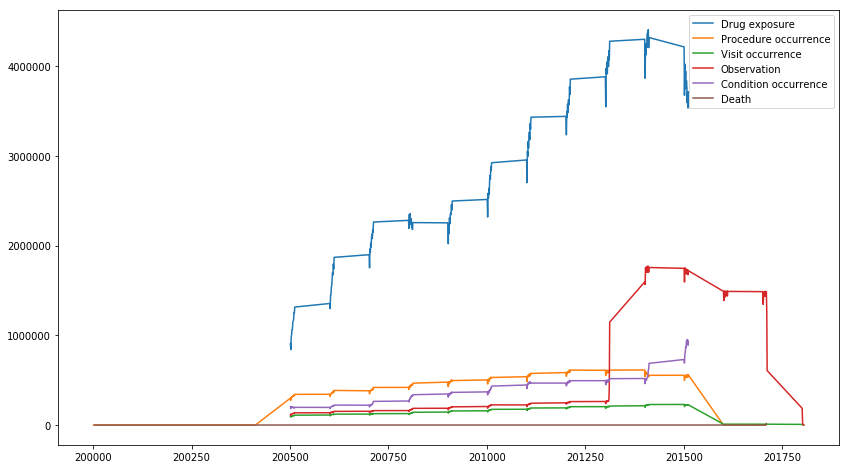

In [22]:
plt.figure(figsize=(14,8))
for table in set(df_datadensity.SERIES_NAME):
    df_sub = df_datadensity.loc[(df_datadensity.SERIES_NAME == table)].sort_values(by='X_CALENDAR_MONTH')
    x = df_sub.X_CALENDAR_MONTH[df_sub.X_CALENDAR_MONTH.values>200000].values
    y = df_sub.Y_RECORD_COUNT[df_sub.X_CALENDAR_MONTH.values>200000].values
    plt.plot(x,y,label=table)
    #df_datadensity.loc[(df_datadensity.SERIES_NAME == table), ['X_CALENDAR_MONTH','Y_RECORD_COUNT']].plot(title='a: 10, b: 20')
# df_datadensity.plot();
plt.legend()
plt.show()

In [23]:
%%bq query --name ageAtFirstObs
 select c1.concept_id as CONCEPT_ID,
        c2.concept_name as CATEGORY,
        ard1.min_value as MIN_VALUE,
        ard1.p10_value as P10_VALUE,
        ard1.p25_value as P25_VALUE,
        ard1.median_value as MEDIAN_VALUE,
        ard1.p75_value as P75_VALUE,
        ard1.p90_value as P90_VALUE,
        ard1.max_value as MAX_VALUE
from (
  select cast(stratum_1 as int64) stratum_1, cast(stratum_2 as int64) stratum_2, min_value, p10_value, p25_value, median_value, p75_value, p90_value, max_value
  FROM test_run_achilles_merge_jan4.fake_achilles_results_dist
  where analysis_id = 806
  GROUP BY analysis_id, stratum_1, stratum_2, min_value, p10_value, p25_value, median_value, p75_value, p90_value, max_value
) ard1
inner join test_run_achilles_merge_jan4.concept c1 on ard1.stratum_1 = c1.concept_id
inner join test_run_achilles_merge_jan4.concept c2 on ard1.stratum_2 = c2.concept_id

In [24]:
df_age_at_first_obs = ageAtFirstObs.execute(output_options=bq.QueryOutput.dataframe()).result()

In [25]:
df_age_at_first_obs.head(10)

,CONCEPT_ID,CATEGORY,MIN_VALUE,P10_VALUE,P25_VALUE,MEDIAN_VALUE,P75_VALUE,P90_VALUE,MAX_VALUE
0,440622,FEMALE,7.0,7.0,7.0,7.0,7.0,7.0,7.0
1,439520,FEMALE,7.0,7.0,7.0,7.0,7.0,7.0,7.0
2,2617403,MALE,9.0,9.0,9.0,9.0,9.0,9.0,9.0
3,443598,MALE,9.0,9.0,9.0,9.0,9.0,9.0,9.0
4,44832558,MALE,9.0,9.0,9.0,9.0,9.0,9.0,9.0
5,2617399,MALE,9.0,9.0,9.0,9.0,9.0,9.0,9.0
6,439346,MALE,10.0,10.0,10.0,10.0,10.0,10.0,10.0
7,2213591,MALE,9.0,9.0,9.0,12.0,12.0,12.0,12.0
8,2617403,FEMALE,12.0,12.0,12.0,12.0,12.0,12.0,12.0
9,2617399,FEMALE,12.0,12.0,12.0,12.0,12.0,12.0,12.0


## Age at first Observation

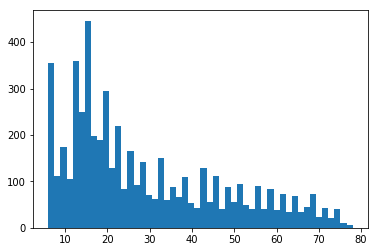

In [26]:
plt.figure()
plt.hist(df_age_at_first_obs.MIN_VALUE.values, bins=50)
plt.show()